In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
# read data
df = pd.read_csv("data/npf_train.csv")

In [3]:
df.head()

,id,date,class4,partlybad,CO2168.mean,CO2168.std,CO2336.mean,CO2336.std,CO242.mean,CO242.std,...,T672.mean,T672.std,T84.mean,T84.std,UV_A.mean,UV_A.std,UV_B.mean,UV_B.std,CS.mean,CS.std
0,1,2000-02-23,nonevent,False,380.528120,0.802001,380.371466,0.889550,381.816207,1.292593,...,-10.730843,1.381815,-10.282754,1.870056,8.356761,4.534937,0.178084,0.123402,0.002546,0.000686
1,2,2000-03-25,Ib,False,373.128684,1.096617,372.980000,1.047750,373.701830,1.259198,...,-2.095641,1.695622,-1.095864,2.090111,12.906779,7.022300,0.333523,0.239981,0.000662,0.000210
2,3,2000-04-06,Ib,False,372.363293,0.626329,372.245689,0.615803,372.847246,0.647279,...,0.991521,1.914186,1.846503,1.954748,14.286261,9.572444,0.418313,0.344386,0.000541,0.000072
3,4,2000-04-11,nonevent,False,381.437442,7.281159,381.380405,7.236002,381.926532,7.294374,...,1.753414,0.340565,2.524931,0.414255,4.945162,3.405652,0.224159,0.192014,0.003710,0.001209
4,5,2000-04-23,II,False,375.426310,3.264246,375.436524,3.110886,375.740215,3.274924,...,10.940107,2.179821,11.441893,3.048699,13.087014,9.771415,0.525591,0.476821,0.003680,0.002160


In [4]:
# create new class that is either event or nonevent
df["class2"] = ["nonevent" if x=="nonevent" else "event" for x in df["class4"]]

In [5]:
# set date as index and drop definitely useless columns (id, partlybad, class4)
del df["date"]
del df["id"]
del df["partlybad"]
del df["class4"]
df.head()

,CO2168.mean,CO2168.std,CO2336.mean,CO2336.std,CO242.mean,CO242.std,CO2504.mean,CO2504.std,Glob.mean,Glob.std,...,T672.std,T84.mean,T84.std,UV_A.mean,UV_A.std,UV_B.mean,UV_B.std,CS.mean,CS.std,class2
0,380.528120,0.802001,380.371466,0.889550,381.816207,1.292593,380.296466,0.968884,236.605353,145.160571,...,1.381815,-10.282754,1.870056,8.356761,4.534937,0.178084,0.123402,0.002546,0.000686,nonevent
1,373.128684,1.096617,372.980000,1.047750,373.701830,1.259198,372.910000,1.004164,252.480327,138.921953,...,1.695622,-1.095864,2.090111,12.906779,7.022300,0.333523,0.239981,0.000662,0.000210,event
2,372.363293,0.626329,372.245689,0.615803,372.847246,0.647279,372.193952,0.596289,269.981547,200.826676,...,1.914186,1.846503,1.954748,14.286261,9.572444,0.418313,0.344386,0.000541,0.000072,event
3,381.437442,7.281159,381.380405,7.236002,381.926532,7.294374,381.381156,7.208287,68.364653,48.560722,...,0.340565,2.524931,0.414255,4.945162,3.405652,0.224159,0.192014,0.003710,0.001209,nonevent
4,375.426310,3.264246,375.436524,3.110886,375.740215,3.274924,375.337059,2.903780,242.192619,190.952026,...,2.179821,11.441893,3.048699,13.087014,9.771415,0.525591,0.476821,0.003680,0.002160,event


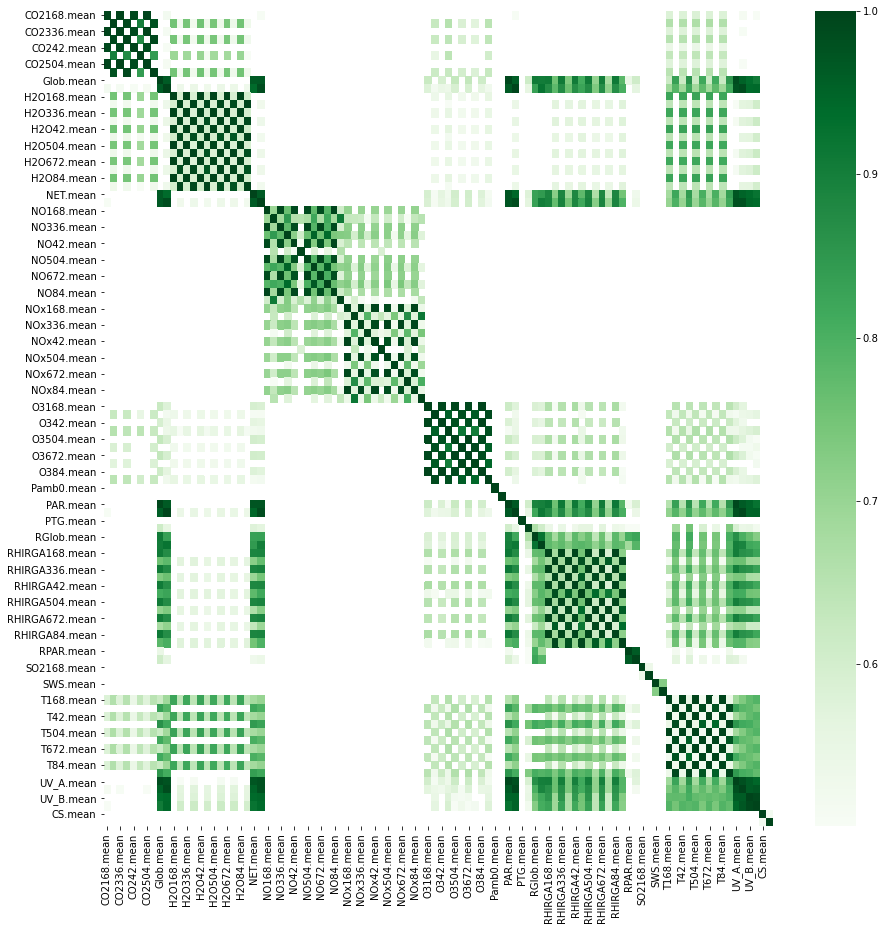

In [6]:
# correlation matrix
plt.figure(figsize=(15,15))
corr = df.corr().abs()
corr = corr[corr>=0.5] #treshold
sns.heatmap(corr, cmap = "Greens")
plt.show()

In [7]:
# select X and y variables
X = df.loc[:, df.columns != 'class2']
y = df["class2"]
# change event strings to ones and non-events to zeros
y = [1 if v=="event" else 0 for v in y]

# Feature selection
## By hand

In [8]:
from sklearn.preprocessing import StandardScaler
# data normalization function
def normalize(X):
    scaler = StandardScaler()
    return scaler.fit_transform(X)

In [9]:
def hand(X):
    # indexes to be deleted
    delidx=[]
    # loop column names
    for i,col in enumerate(X.columns):
        # Drop all .std - columns 
        if col[-4:]==".std":
            delidx.append(i)

        # Drop different altitude columns
        if col[:3]=="CO2" and col!="CO2168.mean":
            delidx.append(i)
        if col[:3]=="H20" and col != "H20168.mean":
            delidx.append(i)        
        if col[:2] == "NO" and col != "NO168.mean" and col[:3] != "NOx":
            delidx.append(i)        
        if col[:3] == "NOx" and col != "NOx168.mean":
            delidx.append(i)
        if col[:2] == "O3" and col != "O3168.mean":
            delidx.append(i)
        if col[:6] == "RHIRGA" and col != "RHIRHGA168.mean":
            delidx.append(i)
        if col[:1] == "T" and col != "T168.mean":
            delidx.append(i)
    X = X.drop(X.columns[delidx], axis=1)

    assert(len(X.columns) == 23)
    
    return X

## Recursive feature elimination

In [12]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression

def rfe(X, plot = False):
    # define estimator
    model = LogisticRegression()
    # 10fold cross validation, eliminate one feature per iteration
    selector = RFECV(model, step=1, cv=10) 
    # Fit to the data
    selector = selector.fit(X, y)
    
    if plot:
        plt.figure(figsize=(12, 6))
        plt.title('Optimal number of features: {}'.format(selector.n_features_), fontsize=18, fontweight='bold', pad=20)
        plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
        plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
        plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_, color='#303F9F', linewidth=3)
        plt.show()
    # Apply dimension reduction to X
    return selector.transform(X)

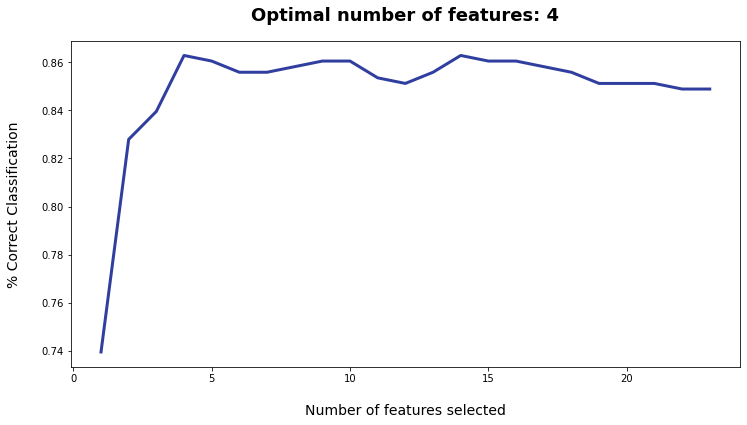

In [13]:
r = rfe(normalize(hand(X)),plot=True)

## PCA feature selection

In [118]:
#Checking how many components should be in PCA

from sklearn.decomposition import PCA

def pca_plot(X):
    pca=PCA()
    pca.fit_transform(X,y) #fit and transform for the normalized X
    variances=pca.explained_variance_ratio_

    plt.figure(figsize=(14,6))
    plt.plot(np.arange(1,len(variances)+1),variances)
    plt.plot(np.arange(1,len(variances)+1),np.cumsum(variances))
    plt.xticks(np.arange(1,len(variances)+1,2))
    plt.legend(['Variance explained','Cumulative sum of variance explained'])
    plt.xlabel("Number of principal components")
    plt.ylabel("Variance explained")
    plt.title("Choosing the number of components for PCA")

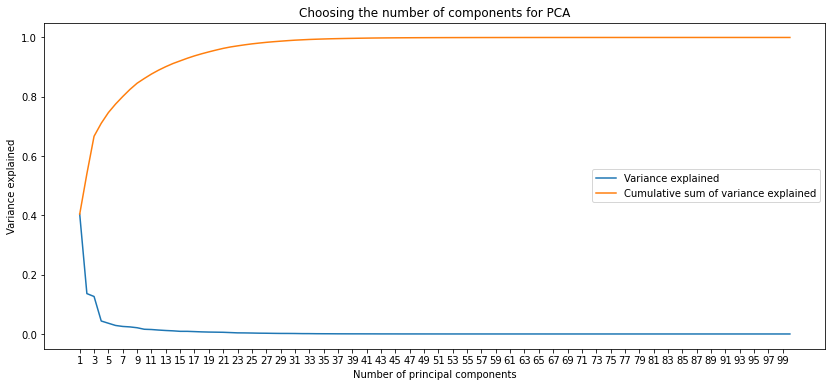

In [119]:
pca_plot(normalize(X))

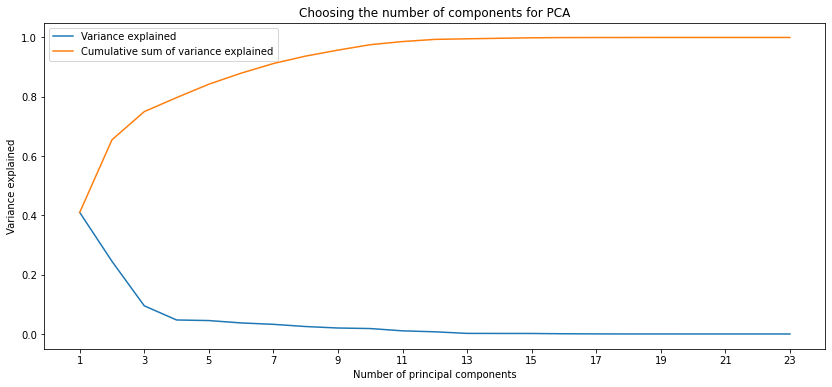

In [120]:
pca_plot(normalize(hand(X)))

In [15]:
from sklearn.decomposition import PCA

def pca(X, n=23):
    # Feature selection using PCA
    # n_components='mle': Minka’s MLE(used to guess the dimension)
    pca = PCA(n_components=n, svd_solver='auto', tol=0.0, iterated_power='auto', random_state=None)
    # fit only on training data
    pca.fit(X)
    # Apply dimensionality reduction to X
    X = pca.transform(X)
    return X

# Model selection

In [32]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.dummy import DummyClassifier


def modeling(model, X):
    cv = KFold(n_splits=10, shuffle=True)
    model = model

    # evaluate model
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    # report performance
    return np.mean(scores), np.std(scores)


In [121]:
# accuracies of the models using hand selected features, pca features and rfe features(takes a while).
names = ["hand", "pca", "rfe", "hand+pca", "hand+rfe", "default"]
# normalize after hand selecting features
selection = [normalize(hand(X)), pca(normalize(X), 30), rfe(normalize(X)), pca(normalize(hand(X)), 11), 
             rfe(normalize(hand(X))), normalize(X)]
models = [("LR", LogisticRegression()), ("SVC", SVC()), ("RF", RandomForestClassifier()),\
          ("ET", ExtraTreesClassifier()),("DT", DecisionTreeClassifier()),("NB", GaussianNB()), \
          ("KNN", KNeighborsClassifier(n_neighbors=3)), ("LD", LinearDiscriminantAnalysis()), \
          ("QD", QuadraticDiscriminantAnalysis()), ("Dummy", DummyClassifier(strategy="most_frequent"))]

na = []
acc = []
err = []

for i in range(len(names)):
    print("\n Feature selection: {}".format(names[i]))
    for name, model in models:
        m, s = modeling(model, selection[i])
        print(name," Accuracy: %6.3f (%6.3f)" % (m, s))
        na.append(name)
        acc.append(m)
        err.append(s)


 Feature selection: hand
LR  Accuracy:  0.858 ( 0.067)
SVC  Accuracy:  0.870 ( 0.047)
RF  Accuracy:  0.858 ( 0.041)
ET  Accuracy:  0.858 ( 0.058)
DT  Accuracy:  0.833 ( 0.049)
NB  Accuracy:  0.840 ( 0.038)
KNN  Accuracy:  0.863 ( 0.055)
LD  Accuracy:  0.858 ( 0.054)
QD  Accuracy:  0.823 ( 0.052)
Dummy  Accuracy:  0.442 ( 0.037)

 Feature selection: pca
LR  Accuracy:  0.884 ( 0.050)
SVC  Accuracy:  0.865 ( 0.046)
RF  Accuracy:  0.874 ( 0.033)
ET  Accuracy:  0.870 ( 0.064)
DT  Accuracy:  0.740 ( 0.056)
NB  Accuracy:  0.700 ( 0.077)
KNN  Accuracy:  0.870 ( 0.042)
LD  Accuracy:  0.879 ( 0.029)
QD  Accuracy:  0.781 ( 0.098)
Dummy  Accuracy:  0.451 ( 0.030)

 Feature selection: rfe
LR  Accuracy:  0.914 ( 0.045)
SVC  Accuracy:  0.891 ( 0.049)
RF  Accuracy:  0.874 ( 0.041)
ET  Accuracy:  0.886 ( 0.055)
DT  Accuracy:  0.833 ( 0.053)
NB  Accuracy:  0.833 ( 0.052)
KNN  Accuracy:  0.858 ( 0.082)
LD  Accuracy:  0.893 ( 0.024)
QD  Accuracy:  0.865 ( 0.047)
Dummy  Accuracy:  0.428 ( 0.068)

 Feature

In [122]:
def colors(l, n=10):
    idx = l.index(max(l))
    colors = []
    for i in range(n):
        if i == idx:
            colors.append('g')
        else:
            colors.append('b')
            
    return colors

In [123]:
def autolabel(rects, ax):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2 - 0.1, 0.05,
                '%6.2f' % (height),
                ha='center', va='bottom')

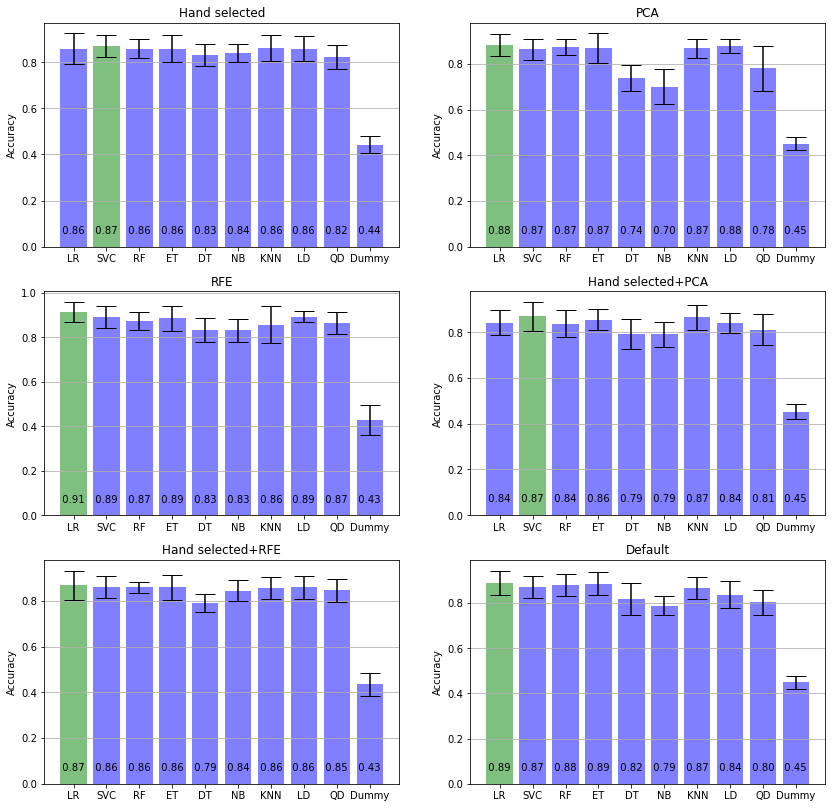

In [124]:
numberOfModels = 10
names = [na[x:x+numberOfModels] for x in range(0,len(na),numberOfModels)]
accuracies = [acc[x:x+numberOfModels] for x in range(0,len(acc),numberOfModels)]
errors = [err[x:x+numberOfModels] for x in range(0,len(err),numberOfModels)]
title = ['Hand selected', 'PCA', 'RFE', 'Hand selected+PCA', 'Hand selected+RFE', 'Default']

fig, ax = plt.subplots(3, 2, figsize=(14,14))
(ax1, ax2), (ax3, ax4), (ax5, ax6) = ax
axes = [ax1,ax2,ax3,ax4,ax5,ax6]

for i in range(len(names)):
    bar = axes[i].bar(names[i], accuracies[i], yerr=errors[i], align='center', alpha=0.5, ecolor='black', capsize=10,
               color = colors(accuracies[i]))
    axes[i].set_ylabel('Accuracy')
    axes[i].set_title('{}'.format(title[i]))
    axes[i].yaxis.grid(True)
    autolabel(bar, axes[i])
plt.show()


# Final model

In [173]:
model = LogisticRegression(penalty='l2', 
                           dual=False, 
                           tol=0.0001, 
                           C=1.0, 
                           fit_intercept=True, 
                           intercept_scaling=1, 
                           class_weight=None, 
                           random_state=None, 
                           solver='lbfgs', 
                           max_iter=100, 
                           multi_class='auto', 
                           verbose=0, 
                           warm_start=False, 
                           n_jobs=None, 
                           l1_ratio=None)

modeling(model, rfe(normalize(X)))

(0.9093023255813953, 0.03362054022046736)